In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


from numpy.polynomial import polynomial as P


##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [4]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [656]:
region = 'ouaga'
sahel = [-10,15,9,19]
x=2
y=1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W

#     ouaga=[-2.52,0.52,11.38,13.38]
#     niamey = [1.13,3.13, 12.51,14.51] #13.5116° N, 2.1254° E
#     timbuktu = [ -2.9,-0.9, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':sahel, 'ouaga':ouaga, 'niamey':niamey, 'timbuktu':timbuktu}
domain = regions[region]

vlist = ['prcp']
ttag='hourly'
xstep = 20

def calc_mcs_stuff(dic, domain):
    m1=5
    m2=10

    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    return dicout

Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [657]:
def calc_mcs(dd):

    obs_mcs_d = pkl.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
    cp4hist_mcs_d = pkl.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
    cp4fut_mcs_d = pkl.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

    obs_mcs = calc_mcs_stuff(obs_mcs_d, dd)
    cp4hist_mcs = calc_mcs_stuff(cp4hist_mcs_d, dd)
    cp4fut_mcs = calc_mcs_stuff(cp4fut_mcs_d, dd)
    
    return cp4hist_mcs, cp4fut_mcs, obs_mcs

In [658]:
cp4, cp4f, obs = calc_mcs(domain)

In [659]:
p95_tcw_hist = np.percentile(cp4.tcwv, 95)
p95_tcw_fut = np.percentile(cp4f.tcwv, 95)

In [660]:
cp4.prcp[cp4.tcwv>=p95_tcw_hist]

9351     28.824302
11724    30.735525
11887     8.334007
4643      0.576079
4707     33.091292
           ...    
8403     22.970649
8422      5.262194
8507     14.846238
9576     25.127056
9944     10.152162
Name: prcp, Length: 152, dtype: float64

In [661]:
p=95
p95_precip_hist = cp4.prcp[cp4.tcwv>=p95_tcw_hist]
p95_precip_fut = cp4f.prcp[cp4f.tcwv>=p95_tcw_fut]

prcp_rel = ((np.percentile(p95_precip_fut,p)-np.percentile(p95_precip_hist,p))/ np.percentile(p95_precip_hist,p)) / ((np.percentile(p95_tcw_fut,p)-np.percentile(p95_tcw_hist,p))/ np.percentile(p95_tcw_hist,p))

In [662]:
prcp_rel

1.3080958210528189

Text(0.5, 1.0, '-0.58')

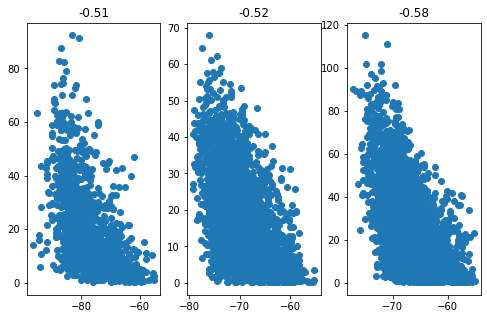

In [663]:

cp4s = [obs.tmin, obs.prcp] # gpm
cp25s = [cp4.tmin,cp4.prcp] #cp4
futur = [cp4f.tmin, cp4f.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





In [664]:
def get_percentile(x, ttag):
    
    if ttag == 'hourly':
        ptag = [0.1]+list(np.arange(xstep,96,xstep))+[99.9]
    else:
        ptag =  [0.1]+list(np.arange(xstep,96,xstep))+[99.9]
        
#     if ttag == 'hourly':
#         ptag = [0.01]+list(np.arange(10,91,10))+[99.99]
#     else:
#         ptag =  [0.01]+list(np.arange(10,91,10))+[99.99]
                         
    return np.percentile(x[np.isfinite(x)], ptag) 

In [665]:
percent=95
valmin = 3
obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, get_percentile(obs.shear, ttag), get_percentile(obs.q925, ttag), obs, vlist, percentile=percent, valmin=valmin)
obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, get_percentile(obs.shear, ttag), get_percentile(obs.theta_e, ttag), obs, vlist, percentile=percent, valmin=valmin)
obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, get_percentile(obs.shear, ttag), get_percentile(obs.tcwv, ttag), obs, vlist, percentile=percent, valmin=valmin)

cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, get_percentile(cp4.shear, ttag), get_percentile(cp4.q925, ttag), cp4, vlist, percentile=percent, valmin=valmin)
cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e,get_percentile(cp4.shear, ttag), get_percentile(cp4.theta_e, ttag), cp4, vlist, percentile=percent, valmin=valmin)
cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, get_percentile(cp4.shear, ttag), get_percentile(cp4.tcwv, ttag), cp4, vlist, percentile=percent, valmin=valmin)

cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.q925, ttag), cp4f, vlist, percentile=percent, valmin=valmin)
cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.theta_e, ttag), cp4f, vlist, percentile=percent, valmin=valmin)
cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.tcwv, ttag), cp4f, vlist, percentile=percent, valmin=valmin)

In [666]:
#xstep = len([0.1]+list(np.arange(10,91,10))+[99.9])-1

In [667]:
#[0.1]+list(np.arange(10,91,10))+[99.9]

In [668]:
def plot_dic_prcp(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['prcp'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': maximum precipitation',
    'valid' : dic['prcp_val'],
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    

In [669]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [670]:
shape = obs_q925['prcp'].shape
shapet = obs_tcwv['prcp'].shape

In [671]:
shape

(6, 6)

In [672]:
def binning_2dhist(prcp, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    pvals = []
    for sh in np.unique(bins):
        
            vvflag = True
            ttflag = True
        
            vals = prcp[(sh==bins)]
            vals[vals==0] = np.nan

            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            #ipdb.set_trace()
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
            if np.sum(np.isfinite(vals))<3:
                #ipdb.set_trace()
                vv = np.nan
                vvflag = False
            pvals.append(np.sum(np.isfinite(vals)))
            
            mean.append(vv)
            if vvflag:
                try:
                    percup.append(np.percentile(vals[np.isfinite(vals)],90)) # 75, 25
                    percdown.append(np.percentile(vals[np.isfinite(vals)],10))
                except:
                    percup.append(np.nan)
                    percdown.append(np.nan)
            else:
                percup.append(np.nan)
                percdown.append(np.nan)
                
                   
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, mean, percup, percdown, pvals

In [673]:
def run_binning(dic, scat):
    
    binns = np.arange(0,101,xstep) # collbins
    binns = np.round(binns[0:-1]+((binns[1::]-binns[0:-1])/2),2)
    #ipdb.set_trace()
    def linregress(bins,data, pval):
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins[pos]
        indata = data[pos]
        return stats.linregress(inbins, indata)

    deltaPS, deltaQPS, sboxplot, pmean,p90,p10, pval = binning_2dhist(dic['prcp'], scat)
    
    collbins = np.round(np.unique(scat),2)
    collbins = np.round(collbins[0:-1]+((collbins[1::]-collbins[0:-1])/2),2)
#     #ipdb.set_trace()
#     slope, intercept, r_value, p_value, std_err = linregress(binns, pmean[0:-1], pval[0:-1])
#     rslope, rintercept, rr_value, rp_value, rstd_err = linregress(collbins, pmean[0:-1], pval[0:-1])
    
    odic = {
#         'slope' : slope,
#         'intercept' : intercept,
#         'rval' : r_value,
#         'pval' : p_value,
#         'std_err' : std_err,
        'prcp_span' : deltaPS,
        'prcp_IQR' : deltaQPS,
        'pbox' : sboxplot,
        'pmean' : pmean[0:-1],
        'p90' : p90[0:-1],
        'p10' : p10[0:-1],
        'bins' : binns,
        'rbins' : collbins,
#         'rslope' : rslope,
#         'rintercept' : rintercept,
#         'rrval' : rr_value,
#         'rpval' : rp_value,
#         'rstd_err' : rstd_err
    }
    
    return odic

In [674]:
# obs_tcwv_shear = run_binning(obs_tcwv,binning_hist(get_percentile(obs.shear, ttag)[np.newaxis,:],shape))
# cp4_tcwv_shear = run_binning(cp4_tcwv,binning_hist(get_percentile(cp4.shear, ttag)[np.newaxis,:],shape))
# cp4f_tcwv_shear = run_binning(cp4f_tcwv,binning_hist(get_percentile(cp4f.shear, ttag)[np.newaxis,:],shape))

obs_shear_tcwv = run_binning(obs_tcwv,get_percentile(obs.tcwv, ttag))
cp4_shear_tcwv = run_binning(cp4_tcwv,get_percentile(cp4.tcwv, ttag))
cp4f_shear_tcwv = run_binning(cp4f_tcwv,get_percentile(cp4f.tcwv, ttag))

10.892607270361331
3.323844663582747
3.915661447070846


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [675]:
cp4_tcwv

{'prcp': array([[35.37662901, 34.94935282, 35.44126733, 33.76952111, 35.14309383,
          0.        ],
        [36.04765549, 39.31423498, 38.27997272, 42.76202511, 37.39051892,
          0.        ],
        [43.37509119, 42.40147033, 37.78163333, 37.80455295, 40.69087595,
          0.        ],
        [43.13314285, 35.68282026, 39.10020007, 37.30008298, 43.71581558,
          0.        ],
        [41.25516296, 44.57900762, 40.6068291 , 42.91291834, 44.79442913,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]]),
 'prcp_val': array([[ 91., 110., 142., 135., 123.,   0.],
        [122., 118., 109., 130., 122.,   0.],
        [ 90., 122., 118., 133., 139.,   0.],
        [130., 130., 126.,  99., 118.,   0.],
        [165., 122., 106., 107.,  99.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]]),
 'xbins': array([ 2.59227919, 14.42613982, 16.86581633, 18.9242169 , 20.67968057,
        26.21152041]),
 'ybins': arr

In [676]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP_'+region+'.csv', index_col='model_name')

In [677]:
cmip_read

{'2030':                 Unnamed: 0  shear_mean  tcw_mean   tcw_hist  shear_hist
 model_name                                                             
 MPI-ESM-MR               0    0.681764  6.279804  48.244044   15.598982
 ACCESS1-0                1    1.521488  7.256251  39.106797   11.369431
 CMCC-CM                  2    0.944005  6.424995  48.882544   14.824049
 MIROC-ESM-CHEM           3   -0.010374  8.212400  42.682097   17.450691
 inmcm4                   4    0.411312  2.080749  41.478374   18.016269
 bcc-csm1-1-m             5   -0.196897  5.023284  41.510425   17.657188
 CSIRO-Mk3-6-0            6    0.628418  4.939753  50.565798   14.591327
 HadGEM2-ES               7    1.587037  8.140177  37.730358   12.666090
 GISS-E2-R                8    0.664832  4.767753  47.157330   18.086881
 NorESM1-ME               9    0.450533  4.885575  39.533447   14.076910
 MIROC-ESM               10   -0.531260  7.752710  42.984471   17.491890
 CCSM4                   11    0.146379  5.

In [678]:
((cmip_read)['2080'])['tcw_mean']/((cmip_read)['2080'])['tcw_hist']

model_name
MPI-ESM-MR        0.347546
ACCESS1-0         0.447072
CMCC-CM           0.367129
MIROC-ESM-CHEM    0.513591
inmcm4            0.173950
bcc-csm1-1-m      0.299316
CSIRO-Mk3-6-0     0.300615
HadGEM2-ES        0.479770
GISS-E2-R         0.251847
NorESM1-ME        0.324188
MIROC-ESM         0.479004
CCSM4             0.292718
MPI-ESM-LR        0.331369
MRI-CGCM3         0.331788
GFDL-ESM2G        0.255147
ACCESS1-3         0.532881
FGOALS-g2         0.269476
BNU-ESM           0.417011
NorESM1-M         0.328344
CESM1-CAM5        0.289103
MIROC5            0.303353
FIO-ESM           0.245464
IPSL-CM5A-MR      0.504113
GISS-E2-H-CC      0.276377
CNRM-CM5          0.280963
GFDL-CM3          0.525862
GISS-E2-H         0.306270
HadGEM2-CC        0.514812
GISS-E2-R-CC      0.273934
IPSL-CM5A-LR      0.483479
GFDL-ESM2M        0.226484
CMCC-CMS          0.404696
bcc-csm1-1        0.281009
MRI-ESM1          0.353731
CanESM2           0.405528
IPSL-CM5B-LR      0.306570
CMCC-CESM        

In [679]:
pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv

percmid = np.arange(0,101,xstep)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

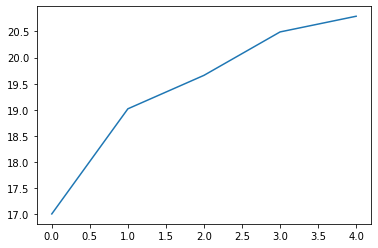

In [680]:
plt.plot((pcp4f['rbins']-pcp4['rbins']))

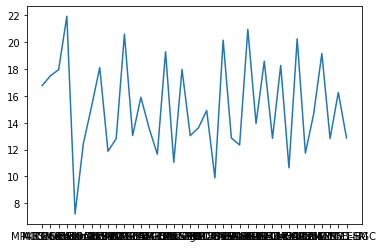

In [681]:
plt.plot((cmip_read['2080']['tcw_mean']))

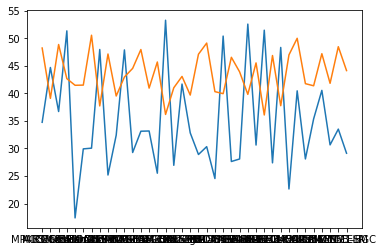

In [682]:
plt.plot((cmip_read['2080']['tcw_mean'])/(cmip_read['2080']['tcw_hist'])*100)
plt.plot((cmip_read['2080']['tcw_hist']))

In [683]:
np.mean(pcp4['rbins'])  # tcw mean from percentile mean

43.916

In [684]:
np.mean(cp4.tcwv) # tcw mean from MCS mean

43.616402184847104

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Scaling per percentile [0.76087705 1.06097084 1.16683393 1.77577425 1.74989592]
Percentage median 1.166833926574283
Percentage abs  1.0731134418237924


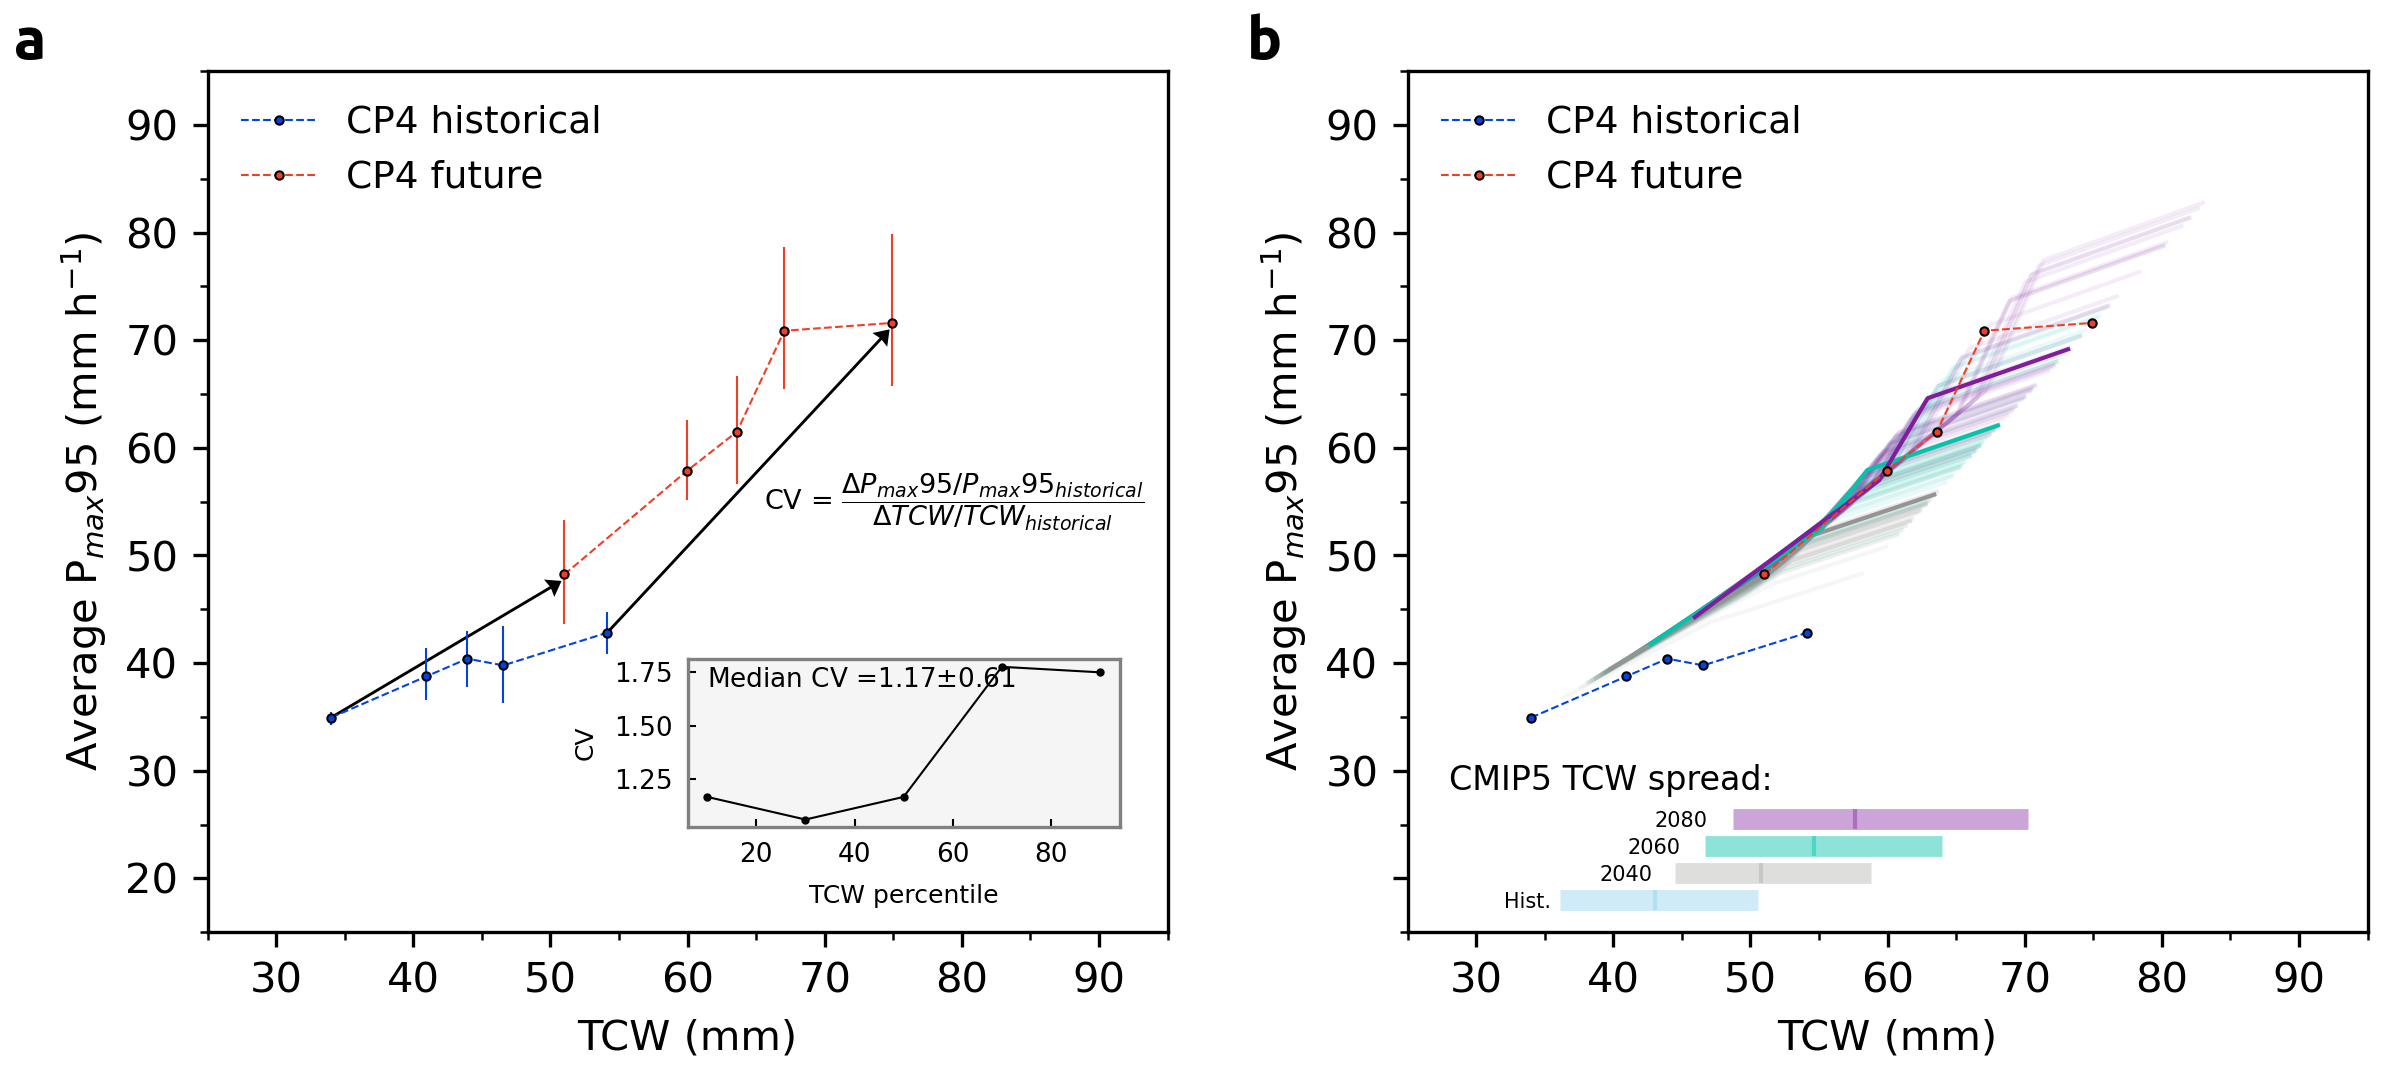

In [685]:
f = plt.figure(figsize=(8,3.5), dpi=300)
widthnorm = 0.40
heightnorm = 0.82
bottomnorm=0.13

left, bottom, width, height = [0.58, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [10.5,13,15.5]
alphas = [0.3,0.45,0.4]
ccolors = ['xkcd:grey', 'xkcd:turquoise', 'xkcd:purple']
dy = 10

#####
spread = ((cmip_read['2040'])['tcw_hist'])
mins = np.min(spread)
maxs = np.max(spread)
median = np.median(spread)
#ipdb.set_trace()
ax.errorbar(np.array(median), np.array(8+dy), xerr=np.array([[median-mins, maxs-median]]).T, color='skyblue', linewidth=5, alpha=0.4, linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)
idss=0
for ids, stry in enumerate(['2040', '2060', '2080']):
    idss += idss+1
    ##########
    spread = ((cmip_read[stry])['tcw_mean'])+((cmip_read[stry])['tcw_hist'])
    mins = np.min(spread)
    maxs = np.max(spread)
    median = np.median(spread)
    #ipdb.set_trace()
    ax.errorbar(np.array(median), np.array(posis[ids]+dy), xerr=np.array([[median-mins, maxs-median]]).T, color=ccolors[ids], linewidth=5, alpha=alphas[ids], linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)

ax.spines['top'].set_visible(True)
ax.spines['top'].set_linewidth(0.8)


ax.text(28,18.25+dy,'CMIP5 TCW spread:', fontsize=8)
ax.text(32,7.25+dy,'Hist.', fontsize=5)
ax.text(39,9.75+dy,'2040', fontsize=5)
ax.text(41,12.25+dy,'2060', fontsize=5)
ax.text(43,14.75+dy,'2080', fontsize=5)
####

# ax.plot(pcp4['rbins'],pcp4['pmean'], color='mediumblue',  label=r'CP4 historical', linestyle='',marker='o', markersize=3)  #marker='o', markersize=1, #cornflowerblue
# ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', label=r'CP4 future', linestyle='',marker='o', markersize=3) #, marker='o', markersize=1


histline = np.array(pcp4['pmean']) #np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept']))
futline = np.array(pcp4f['pmean']) #np.array(pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])

ax.plot(pcp4['rbins'],histline, color='xkcd:blue', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 historical', mfc='xkcd:blue',  marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)
ax.plot(pcp4f['rbins'], futline, color='xkcd:tomato', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4 future', mfc='xkcd:tomato', marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)


pick = np.array([0,-1])
ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_yticklabels(['','',30,40,50,60,70,80,90])
ax.legend(loc='upper left', frameon=False, fontsize=9)
coll = []
abss = []
collmm = []

for ids, percs in enumerate(percents):

    ppabs = (futline[ids]-histline[ids])/(pcp4f['rbins'][ids]-pcp4['rbins'][ids])

    aprcp = (futline[ids]-histline[ids])/histline[ids]
    btcw = (pcp4f['rbins'][ids]-pcp4['rbins'][ids])/pcp4['rbins'][ids]
    pperc = aprcp/btcw
    coll.append(pperc)

    abss.append(ppabs)
    
coll = np.array(coll)


        
print('Scaling per percentile', coll)
    
for yyinds, yy in enumerate(['2040', '2060', '2080']):
    cmip_rrel = []
    cmip_rel = (cmip_read[yy]['tcw_mean'])/(cmip_read[yy]['tcw_hist'])  #cp4_historical_domainMean #/np.mean(cp4.tcwv)# relative to average MCS tcw ; i.e. if this is the change that ocurrs relative to MCS baseline tcw / compares domain-wide aggregate to domain-wide aggregate
    for crbins in (cmip_read[yy]['tcw_mean']):
        cmip_rrel.append(crbins/np.array(pcp4['rbins']))
    
    cmip_rrel = np.array(cmip_rrel)
    #ipdb.set_trace()
        
    cmip_diff = (cmip_read[yy]['tcw_mean'])
 
    for cinds, cmip_di in enumerate(cmip_rel):
        cmipfut = np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*cmip_di
        cmean = histline+histline*(cmip_di)*coll
        ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

        
#     for cinds, cmip_di in enumerate(cmip_read[yy]['tcw_mean']):
#         cmipfut = np.array(pcp4['rbins'])+cmip_di
#         cmean = histline+np.array(coll)*(cmip_di) 
#         ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

    cmean = histline+histline*(np.mean(cmip_rel))*coll #

    ax.plot(np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*np.mean(cmip_rel), cmean, color=ccolors[yyinds], zorder=95, linewidth=1, alpha=1, markersize=2)
    
    #reconstructed CP4 RAINFALL
   # ax.plot(np.array(pcp4f['rbins']), histline+histline*((pcp4f['rbins']-pcp4['rbins'])/pcp4['rbins'])*coll, color='r', linewidth=2)
    
print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')


#####################################################################################################################
left, bottom, width, height = [0.08, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [79,81,83]
alphas = [0.3,0.45,0.6]


ax.plot(pcp4['rbins'],pcp4['pmean'], color='xkcd:blue',  label=r'CP4 historical', linestyle='dashed',marker='o', markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5)  #marker='o', markersize=1, #cornflowerblue
ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='xkcd:tomato', label=r'CP4 future', linestyle='dashed', marker='o',markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5) #, marker='o', markersize=1
ax.errorbar(pcp4['rbins'], pcp4['pmean'], yerr=[np.array(pcp4['pmean'])-np.array(pcp4['p10']),np.array(pcp4['p90'])-np.array(pcp4['pmean'])], color='xkcd:blue', linewidth=0.5, linestyle='')
ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], yerr=[np.array(pcp4f['pmean'])-np.array(pcp4f['p10']),np.array(pcp4f['p90'])-np.array(pcp4f['pmean'])], color='xkcd:tomato', linewidth=0.5, linestyle='')
pick = np.array([0,-1])

yh = (histline)[pick]
xh = pcp4['rbins'][pick]
yf = (futline)[pick]
xf = pcp4f['rbins'][pick]
ax.quiver(xh, yh,(xf)-xh-0.2,yf-yh-0.6, angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=0, headwidth=7, linestyle='dotted')

# ax.plot(pcp4['rbins'],histline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
# ax.plot(pcp4f['rbins'], futline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)


ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.legend(loc='upper left', frameon=False, fontsize=9)
ax.text(0.58, 0.49,r'CV = $\dfrac{\Delta P_{max}95 / P_{max}95_{historical}}{\Delta TCW / TCW_{historical}}$', transform=ax.transAxes, fontsize=6.5) # 0.83



#ax.text(0.58, 0.41,r'$\dfrac{\delta P_{max} 95}{\delta TCW}$: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=6.5)

coll[0] = coll[2]
fdic = {'rel': np.array(coll), 'abs' : abss, 'tcw_hist' : pcp4['rbins'], 'prcp_hist' :  pcp4['pmean'], 'tcw_fut' : pcp4f['rbins'], 'prcp_fut' :  pcp4f['pmean']} #, 'futslope': pcp4f['rslope'], 'histslope' : pcp4['rslope'],  'futinter' : pcp4f['rintercept'], 'histinter' : pcp4['rintercept'], 
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_'+region+'.p', "wb"))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('Average P$_{max}$95 (mm h$^{-1}$)')

left, bottom, width, height = [0.28, 0.23, 0.18, 0.16] #[0.275, 0.2, 0.20, 0.27]
ax3 = f.add_axes([left, bottom, width, height])
#ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.text(0.52, 0.285,r'Median CV ='+str(np.round(np.median(coll),2))+'$\pm$'+str(np.round(np.max(coll)-np.median(coll),2)), transform=ax.transAxes, fontsize=6.3) # 0.83
ax3.set_xlabel('TCW percentile', fontsize=6)
ax3.set_ylabel('CV',fontsize=6)

# ax3.set_xticklabels('')
# ax3.set_yticklabels('')
# ax3.set_xlim(32,62)
# ax3.set_ylim(30,85)

for axis in ['top','bottom','left','right']:
  
  ax3.spines[axis].set_color('grey')
# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)
ax3.tick_params(direction='in', length=2, width=0.5, colors='k', labelsize=6.3)
ax3.set_facecolor('whitesmoke')

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)


plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_hourly_OBS_CP4_TCWV_CMIPscaling_relative_CMIP_9-19N_20masked_CV_0.1mm_'+region+'.jpg')

In [686]:
def relate_climate(hist_tcw, fut_tcw):
    ddic = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))
    hist_pcp = ddic['histslope']*hist_tcw+ddic['histinter']
    fut_pcp = ddic['futslope']*fut_tcw+ddic['futinter']
    prel = (fut_pcp-hist_pcp)/hist_pcp * 100
    trel = (fut_tcw-hist_tcw)/hist_tcw * 100
    dic = {'hist_pcp' : hist_pcp, 'fut_pcp' : fut_pcp, 'rel_pchange' : prel, 'rel_tchange' : trel}

    return dic